In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from bs4 import BeautifulSoup #import library to parse html code

print('Libraries imported.')

Libraries imported.


### Scrap wiki website and transform the table info into dataframe

In [26]:
request_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
request = requests.get(request_url)
#extract html text from the request
toronto_html = request.text
toronto_soup = BeautifulSoup(toronto_html)

In [38]:
values = toronto_soup.table.find_all('td')

In [39]:
values = [i.get_text() for i in values]

In [40]:
values = [i.strip() for i in values]

In [41]:
values = ['NA' if i=='Not assigned' else i  for i in values ]

In [422]:
#since thera are three values describing one place list slicing can be used
postcode = values[0::3]
borough = values[1::3]
neighborhood = values[2::3]

In [423]:
#check the lenght of each list
print(len(postcode))
print(len(borough))
print(len(neighborhood))

289
289
289


In [483]:
toronto_df = pd.DataFrame({'PostalCode':postcode,
                           'Borough':borough,
                           'Neighborhood':neighborhood})
toronto_grouped = toronto_df.groupby(['PostalCode', 'Borough'], as_index=False, sort=False)
toronto_grouped = toronto_grouped['Neighborhood'].apply(lambda x: ', '.join(x))
toronto_grouped = pd.DataFrame(toronto_grouped).reset_index()
toronto_grouped.columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_grouped = toronto_grouped[toronto_grouped['Borough']!= 'NA']
toronto_grouped.reset_index(inplace=True)
toronto_grouped.drop(['index'], axis=1, inplace=True)
toronto_grouped[toronto_grouped['Neighborhood']=='NA']

PostalCode       Borough Neighborhood
4        M7A  Queen's Park           NA

In [484]:
toronto_grouped.iloc[4]['Neighborhood'] = toronto_grouped.iloc[4]['Borough']

In [487]:
toronto_grouped.head(12)

PostalCode           Borough  \
0         M3A        North York   
1         M4A        North York   
2         M5A  Downtown Toronto   
3         M6A        North York   
4         M7A      Queen's Park   
5         M9A         Etobicoke   
6         M1B       Scarborough   
7         M3B        North York   
8         M4B         East York   
9         M5B  Downtown Toronto   
10        M6B        North York   
11        M9B         Etobicoke   

                                         Neighborhood  
0                                           Parkwoods  
1                                    Victoria Village  
2                           Harbourfront, Regent Park  
3                    Lawrence Heights, Lawrence Manor  
4                                        Queen's Park  
5                                    Islington Avenue  
6                                      Rouge, Malvern  
7                                     Don Mills North  
8                     Woodbine Gardens, Parkview Hill  
9                            Ryerson, Garden District  
10                                          Glencairn  
11  Cloverdale, Islington, Martin Grove, Princess ...

In [488]:
toronto_grouped.shape

(103, 3)

In [489]:
toronto_with_coordinates = pd.merge(toronto_grouped, coordinates, on='PostalCode')

In [491]:
toronto_with_coordinates.head(12)

PostalCode           Borough  \
0         M3A        North York   
1         M4A        North York   
2         M5A  Downtown Toronto   
3         M6A        North York   
4         M7A      Queen's Park   
5         M9A         Etobicoke   
6         M1B       Scarborough   
7         M3B        North York   
8         M4B         East York   
9         M5B  Downtown Toronto   
10        M6B        North York   
11        M9B         Etobicoke   

                                         Neighborhood   Latitude  Longitude  
0                                           Parkwoods  43.753259 -79.329656  
1                                    Victoria Village  43.725882 -79.315572  
2                           Harbourfront, Regent Park  43.654260 -79.360636  
3                    Lawrence Heights, Lawrence Manor  43.718518 -79.464763  
4                                        Queen's Park  43.662301 -79.389494  
5                                    Islington Avenue  43.667856 -79.532242  
6                                      Rouge, Malvern  43.806686 -79.194353  
7                                     Don Mills North  43.745906 -79.352188  
8                     Woodbine Gardens, Parkview Hill  43.706397 -79.309937  
9                            Ryerson, Garden District  43.657162 -79.378937  
10                                          Glencairn  43.709577 -79.445073  
11  Cloverdale, Islington, Martin Grove, Princess ...  43.650943 -79.554724

### The cluster part  
I'm gonna provide my analysis based on the all neighborhoods so I need to preapre another dataframe   
without joining neighorhoods together.

In [48]:
toronto_df = toronto_df[['PostalCode', 'Borough', 'Neighborhood']]

In [468]:
#remove rows with NA value
toronto_df = toronto_df[toronto_df['Borough']!='NA']

In [469]:
toronto_df.shape

(212, 3)

In [52]:
toronto_df[toronto_df['Neighborhood']=='NA']

PostalCode       Borough Neighborhood
8        M7A  Queen's Park           NA

In [53]:
#reset index
toronto_df.reset_index(inplace=True)
toronto_df.drop(['index'], inplace=True, axis=1)

#### Data cleaning
Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.
If a cell has a borough but a not assigned neighborhood, then the neighborhood will be the same as the borough.


In [56]:
toronto_df[toronto_df['Neighborhood']=='NA']

PostalCode       Borough Neighborhood
6        M7A  Queen's Park           NA

In [57]:
toronto_df.iloc[6]['Neighborhood'] = toronto_df.iloc[6]['Borough']

In [58]:
toronto_df.iloc[6]

PostalCode               M7A
Borough         Queen's Park
Neighborhood    Queen's Park
Name: 6, dtype: object

In [59]:
toronto_df[toronto_df['PostalCode']=='M5A']

PostalCode           Borough  Neighborhood
2        M5A  Downtown Toronto  Harbourfront
3        M5A  Downtown Toronto   Regent Park

In [60]:
toronto_df.iloc[2]['Neighborhood'] = toronto_df.iloc[2]['Neighborhood'] + ', ' + toronto_df.iloc[3]['Neighborhood']
toronto_df.index = [i for i in range(0,len(toronto_df.index))]

Read the file with cocordiantes and update dataframe with borough by adding latitude and longitude

In [63]:
coordinates = pd.read_csv('./Geospatial_Coordinates.csv')

In [64]:
coordinates.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [65]:
coordinates.rename(columns ={'Postal Code':'PostalCode'}, inplace=True)

In [66]:
toronto_merge = pd.merge(toronto_df, coordinates, on='PostalCode')

In [67]:
toronto_merge.head()

PostalCode           Borough               Neighborhood   Latitude  \
0        M3A        North York                  Parkwoods  43.753259   
1        M4A        North York           Victoria Village  43.725882   
2        M5A  Downtown Toronto  Harbourfront, Regent Park  43.654260   
3        M5A  Downtown Toronto                Regent Park  43.654260   
4        M6A        North York           Lawrence Heights  43.718518   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.360636  
4 -79.464763

In [103]:
toronto_merge.shape

(212, 5)

In [269]:
# create map of Toronto neighborhoods using latitude and longitude values
latitude = 43.753259
longitude = -79.329656
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_merge['Latitude'], toronto_merge['Longitude'], toronto_merge['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [278]:
CLIENT_ID = '0EJ3W3T31AZSLAINH5VBFWLOZGRC2UWPH20XEVRTT2PRWAOK' # your Foursquare ID
CLIENT_SECRET = 'AL3MH0MTRRR0JWMJMSRZOBMSROZXKASPOR4ARNHNZJDLNXYD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 5000

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 0EJ3W3T31AZSLAINH5VBFWLOZGRC2UWPH20XEVRTT2PRWAOK
CLIENT_SECRET:AL3MH0MTRRR0JWMJMSRZOBMSROZXKASPOR4ARNHNZJDLNXYD


In [271]:
def getNearbyVenues(borough, neighborhood, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough, neighborhood, lat, lng in zip(borough, neighborhood, latitudes, longitudes):
        #print(neighborhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            neighborhood,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [279]:
toronto_venus = getNearbyVenues(toronto_merge['Borough'],
                                toronto_merge['Neighborhood'], 
                                toronto_merge['Latitude'], 
                                toronto_merge['Longitude'],
                                radius=radius)

In [283]:
toronto_venus.shape

(20977, 8)

In [285]:
#in case chosen radius( = 5000) would overlap two neighborhoods remove duplicates
toronto_final = toronto_venus.drop_duplicates()

In [286]:
toronto_final.head()

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North York    Parkwoods              43.753259              -79.329656   
1  North York    Parkwoods              43.753259              -79.329656   
2  North York    Parkwoods              43.753259              -79.329656   
3  North York    Parkwoods              43.753259              -79.329656   
4  North York    Parkwoods              43.753259              -79.329656   

                         Venue  Venue Latitude  Venue Longitude  \
0              Allwyn's Bakery       43.759840       -79.324719   
1           Darband Restaurant       43.755194       -79.348498   
2  Donalda Golf & Country Club       43.752816       -79.342741   
3                   LA Fitness       43.747665       -79.347077   
4         Galleria Supermarket       43.753520       -79.349518   

              Venue Category  
0       Caribbean Restaurant  
1  Middle Eastern Restaurant  
2                Golf Course  
3       Gym / Fitness Center  
4                Supermarket

In [287]:
#save for later in case of 
toronto_final.to_csv('toronto_venues.csv')

### Analize each neighborhood  
Check if there are similar neighborhoods based on venues proliferation.

In [289]:
toronto_onehot = pd.get_dummies(toronto_final['Venue Category'], prefix='', prefix_sep='')

In [290]:
toronto_onehot.head()

Afghan Restaurant  African Restaurant  Airport  Airport Lounge  \
0                  0                   0        0               0   
1                  0                   0        0               0   
2                  0                   0        0               0   
3                  0                   0        0               0   
4                  0                   0        0               0   

   American Restaurant  Aquarium  Art Gallery  Arts & Crafts Store  \
0                    0         0            0                    0   
1                    0         0            0                    0   
2                    0         0            0                    0   
3                    0         0            0                    0   
4                    0         0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   0                0                0   
1                 0                   0                0                0   
2                 0                   0                0                0   
3                 0                   0                0                0   
4                 0                   0                0                0   

   BBQ Joint  Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0                0           0       0     0    0               0   
1          0                0           0       0     0    0               0   
2          0                0           0       0     0    0               0   
3          0                0           0       0     0    0               0   
4          0                0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  Beer Bar  \
0                 0                 0                   0      0         0   
1                 0                 0                   0      0         0   
2                 0                 0                   0      0         0   
3                 0                 0                   0      0         0   
4                 0                 0                   0      0         0   

   Beer Store  Big Box Store  Bike Shop  Bistro  Bookstore  Boutique  \
0           0              0          0       0          0         0   
1           0              0          0       0          0         0   
2           0              0          0       0          0         0   
3           0              0          0       0          0         0   
4           0              0          0       0          0         0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0              0                     0               0        0            0   
1              0                     0               0        0            0   
2              0                     0               0        0            0   
3              0                     0               0        0            0   
4              0                     0               0        0            0   

   Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  \
0       0                0       0         0             0              0   
1       0                0       0         0             0              0   
2       0                0       0         0             0              0   
3       0                0       0         0             0              0   
4       0                0       0         0             0              0   

   Bus Line  Bus Station  Butcher  Café  Camera Store  Campground  \
0         0            0        0     0             0           0   
1         0            0        0     0             0           0   
2         0            0        0     0             0           0   
3         0            0        0     0             0           0   
4         0            0        

In [292]:
toronto_onehot['Neighborhood'] = toronto_final['Neighborhood']

In [294]:
#let the Neighorhood column be the first one
fixed_columns = [name for name in toronto_onehot.columns.get_values() if name != 'Neighborhood']
fixed_columns = ['Neighborhood'] + fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]

Sum up all venues in one neighborhood to get density of venues in all neighborhoods. 

In [342]:
toronto_grouped = toronto_onehot.groupby(['Neighborhood']).mean().reset_index()

In [343]:
toronto_grouped.head()

Neighborhood  Afghan Restaurant  African Restaurant  Airport  \
0         Adelaide                0.0                 0.0      0.0   
1        Agincourt                0.0                 0.0      0.0   
2  Agincourt North                0.0                 0.0      0.0   
3   Albion Gardens                0.0                 0.0      0.0   
4        Alderwood                0.0                 0.0      0.0   

   Airport Lounge  American Restaurant  Aquarium  Art Gallery  \
0             0.0                 0.01      0.01         0.02   
1             0.0                 0.01      0.00         0.00   
2             0.0                 0.01      0.00         0.00   
3             0.0                 0.00      0.00         0.00   
4             0.0                 0.01      0.00         0.00   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Dealership  \
0                 0.02            0.0000                 0.0           0.0000   
1                 0.01            0.0100                 0.0           0.0000   
2                 0.01            0.0200                 0.0           0.0000   
3                 0.00            0.0375                 0.0           0.0125   
4                 0.01            0.0100                 0.0           0.0000   

   Automotive Shop  BBQ Joint  Badminton Court  Bagel Shop  Bakery   Bank  \
0              0.0       0.00              0.0         0.0  0.0000  0.000   
1              0.0       0.00              0.0         0.0  0.0200  0.000   
2              0.0       0.01              0.0         0.0  0.0300  0.000   
3              0.0       0.00              0.0         0.0  0.0125  0.025   
4              0.0       0.01              0.0         0.0  0.0400  0.000   

   Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.0             0.0              0.02               0.0   
1  0.0             0.0              0.00               0.0   
2  0.0             0.0              0.00               0.0   
3  0.0             0.0              0.00               0.0   
4  0.0             0.0              0.00               0.0   

   Basketball Stadium  Beach  Beer Bar  Beer Store  Big Box Store  Bike Shop  \
0                0.01    0.0      0.01      0.0000         0.0000        0.0   
1                0.00    0.0      0.00      0.0000         0.0000        0.0   
2                0.00    0.0      0.00      0.0000         0.0000        0.0   
3                0.00    0.0      0.00      0.0125         0.0125        0.0   
4                0.00    0.0      0.00      0.0000         0.0000        0.0   

   Bistro  Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  \
0     0.0       0.00       0.0            0.0                   0.0   
1     0.0       0.02       0.0            0.0                   0.0   
2     0.0       0.01       0.0            0.0                   0.0   
3     0.0       0.00       0.0            0.0                   0.0   
4     0.0       0.01       0.0            0.0                   0.0   

   Breakfast Spot  Brewery  Bridal Shop  Bridge  Bubble Tea Shop  Buffet  \
0          0.0000     0.01          0.0     0.0             0.00     0.0   
1          0.0200     0.00          0.0     0.0             0.00     0.0   
2          0.0300     0.00          0.0     0.0             0.05     0.0   
3          0.0125     0.00          0.0     0.0             0.00     0.0   
4          0.0200     0.02          0.0     0.0             0.00     0.0   

   Building  Burger Joint  Burrito Place  Bus Line  Bus Station  Butcher  \
0       0.0         0.000           0.01       0.0          0.0      0.0   
1       0.0         0.020           0.00       0.0          0.0      0.0   
2       0.0         0.010           0.00       0.0          0.0      0.0   
3       0.0         0.025           0.00       0.0          0.0      0.0   
4       0.0         0.040           0.03       0.0          0.0      0.0   

     Café  Camera Store  Campground  Candy Store 

In [344]:
toronto_grouped.shape

(210, 256)

## Cluster neighborhoods

In [347]:
number_of_clusters = 5
neighborhood = toronto_grouped['Neighborhood']
toronto_grouped_cluster = toronto_grouped.drop('Neighborhood', axis=1)
clusters = KMeans(number_of_clusters, init='k-means++', n_init=1000)
clusters.fit(toronto_grouped_cluster)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=1000, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [348]:
clusters.labels_[0:10]

array([2, 4, 4, 1, 0, 0, 2, 0, 1, 0], dtype=int32)

In [349]:
toronto_clusters = toronto_grouped_cluster.copy() 

In [350]:
toronto_clusters['Cluster label'] = clusters.labels_

In [351]:
toronto_clusters['Neighborhood'] = neighborhood

In [352]:
toronto_clusters.head()

Afghan Restaurant  African Restaurant  Airport  Airport Lounge  \
0                0.0                 0.0      0.0             0.0   
1                0.0                 0.0      0.0             0.0   
2                0.0                 0.0      0.0             0.0   
3                0.0                 0.0      0.0             0.0   
4                0.0                 0.0      0.0             0.0   

   American Restaurant  Aquarium  Art Gallery  Arts & Crafts Store  \
0                 0.01      0.01         0.02                 0.02   
1                 0.01      0.00         0.00                 0.01   
2                 0.01      0.00         0.00                 0.01   
3                 0.00      0.00         0.00                 0.00   
4                 0.01      0.00         0.00                 0.01   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0            0.0000                 0.0           0.0000              0.0   
1            0.0100                 0.0           0.0000              0.0   
2            0.0200                 0.0           0.0000              0.0   
3            0.0375                 0.0           0.0125              0.0   
4            0.0100                 0.0           0.0000              0.0   

   BBQ Joint  Badminton Court  Bagel Shop  Bakery   Bank  Bar  Baseball Field  \
0       0.00              0.0         0.0  0.0000  0.000  0.0             0.0   
1       0.00              0.0         0.0  0.0200  0.000  0.0             0.0   
2       0.01              0.0         0.0  0.0300  0.000  0.0             0.0   
3       0.00              0.0         0.0  0.0125  0.025  0.0             0.0   
4       0.01              0.0         0.0  0.0400  0.000  0.0             0.0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  Beer Bar  \
0              0.02               0.0                0.01    0.0      0.01   
1              0.00               0.0                0.00    0.0      0.00   
2              0.00               0.0                0.00    0.0      0.00   
3              0.00               0.0                0.00    0.0      0.00   
4              0.00               0.0                0.00    0.0      0.00   

   Beer Store  Big Box Store  Bike Shop  Bistro  Bookstore  Boutique  \
0      0.0000         0.0000        0.0     0.0       0.00       0.0   
1      0.0000         0.0000        0.0     0.0       0.02       0.0   
2      0.0000         0.0000        0.0     0.0       0.01       0.0   
3      0.0125         0.0125        0.0     0.0       0.00       0.0   
4      0.0000         0.0000        0.0     0.0       0.01       0.0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0            0.0                   0.0          0.0000     0.01          0.0   
1            0.0                   0.0          0.0200     0.00          0.0   
2            0.0                   0.0          0.0300     0.00          0.0   
3            0.0                   0.0          0.0125     0.00          0.0   
4            0.0                   0.0          0.0200     0.02          0.0   

   Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  \
0     0.0             0.00     0.0       0.0         0.000           0.01   
1     0.0             0.00     0.0       0.0         0.020           0.00   
2     0.0             0.05     0.0       0.0         0.010           0.00   
3     0.0             0.00     0.0       0.0         0.025           0.00   
4     0.0             0.00     0.0       0.0         0.040           0.03   

   Bus Line  Bus Station  Butcher    Café  Camera Store  Campground  \
0       0.0          0.0      0.0  0.0400           0.0         0.0   
1       0.0          0.0      0.0  0.0000           0.0         0.0   
2       0.0          0.0      0.0  0.0000           0.0         0.0   
3       0.0          0.0      0.0  0.0125           0.0         0.0   
4       0.0     

Sum all the venuse based on frequency in each cluster

In [353]:
cluster_1 = toronto_clusters[toronto_clusters['Cluster label'] == 0]
cluster_1_sum = cluster_1.sum(axis=0)[0:-2]
top_10_cluster_1 = cluster_1_sum.sort_values(ascending=False)[0:10]

In [354]:
cluster_2 = toronto_clusters[toronto_clusters['Cluster label'] == 1]
cluster_2_sum = cluster_2.sum(axis=0)[0:-2]
top_10_cluster_2 = cluster_2_sum.sort_values(ascending=False)[0:10]

In [355]:
cluster_3 = toronto_clusters[toronto_clusters['Cluster label'] == 2]
cluster_3_sum = cluster_3.sum(axis=0)[0:-2]
top_10_cluster_3 = cluster_3_sum.sort_values(ascending=False)[0:10]

In [356]:
cluster_4 = toronto_clusters[toronto_clusters['Cluster label'] == 3]
cluster_4_sum = cluster_4.sum(axis=0)[0:-2]
top_10_cluster_4 = cluster_4_sum.sort_values(ascending=False)[0:10]

In [357]:
cluster_5 = toronto_clusters[toronto_clusters['Cluster label'] == 4]
cluster_5_sum = cluster_5.sum(axis=0)[0:-2]
top_10_cluster_5 = cluster_5_sum.sort_values(ascending=False)[0:10]

In [358]:
import matplotlib.pyplot as plt 
import seaborn as sns

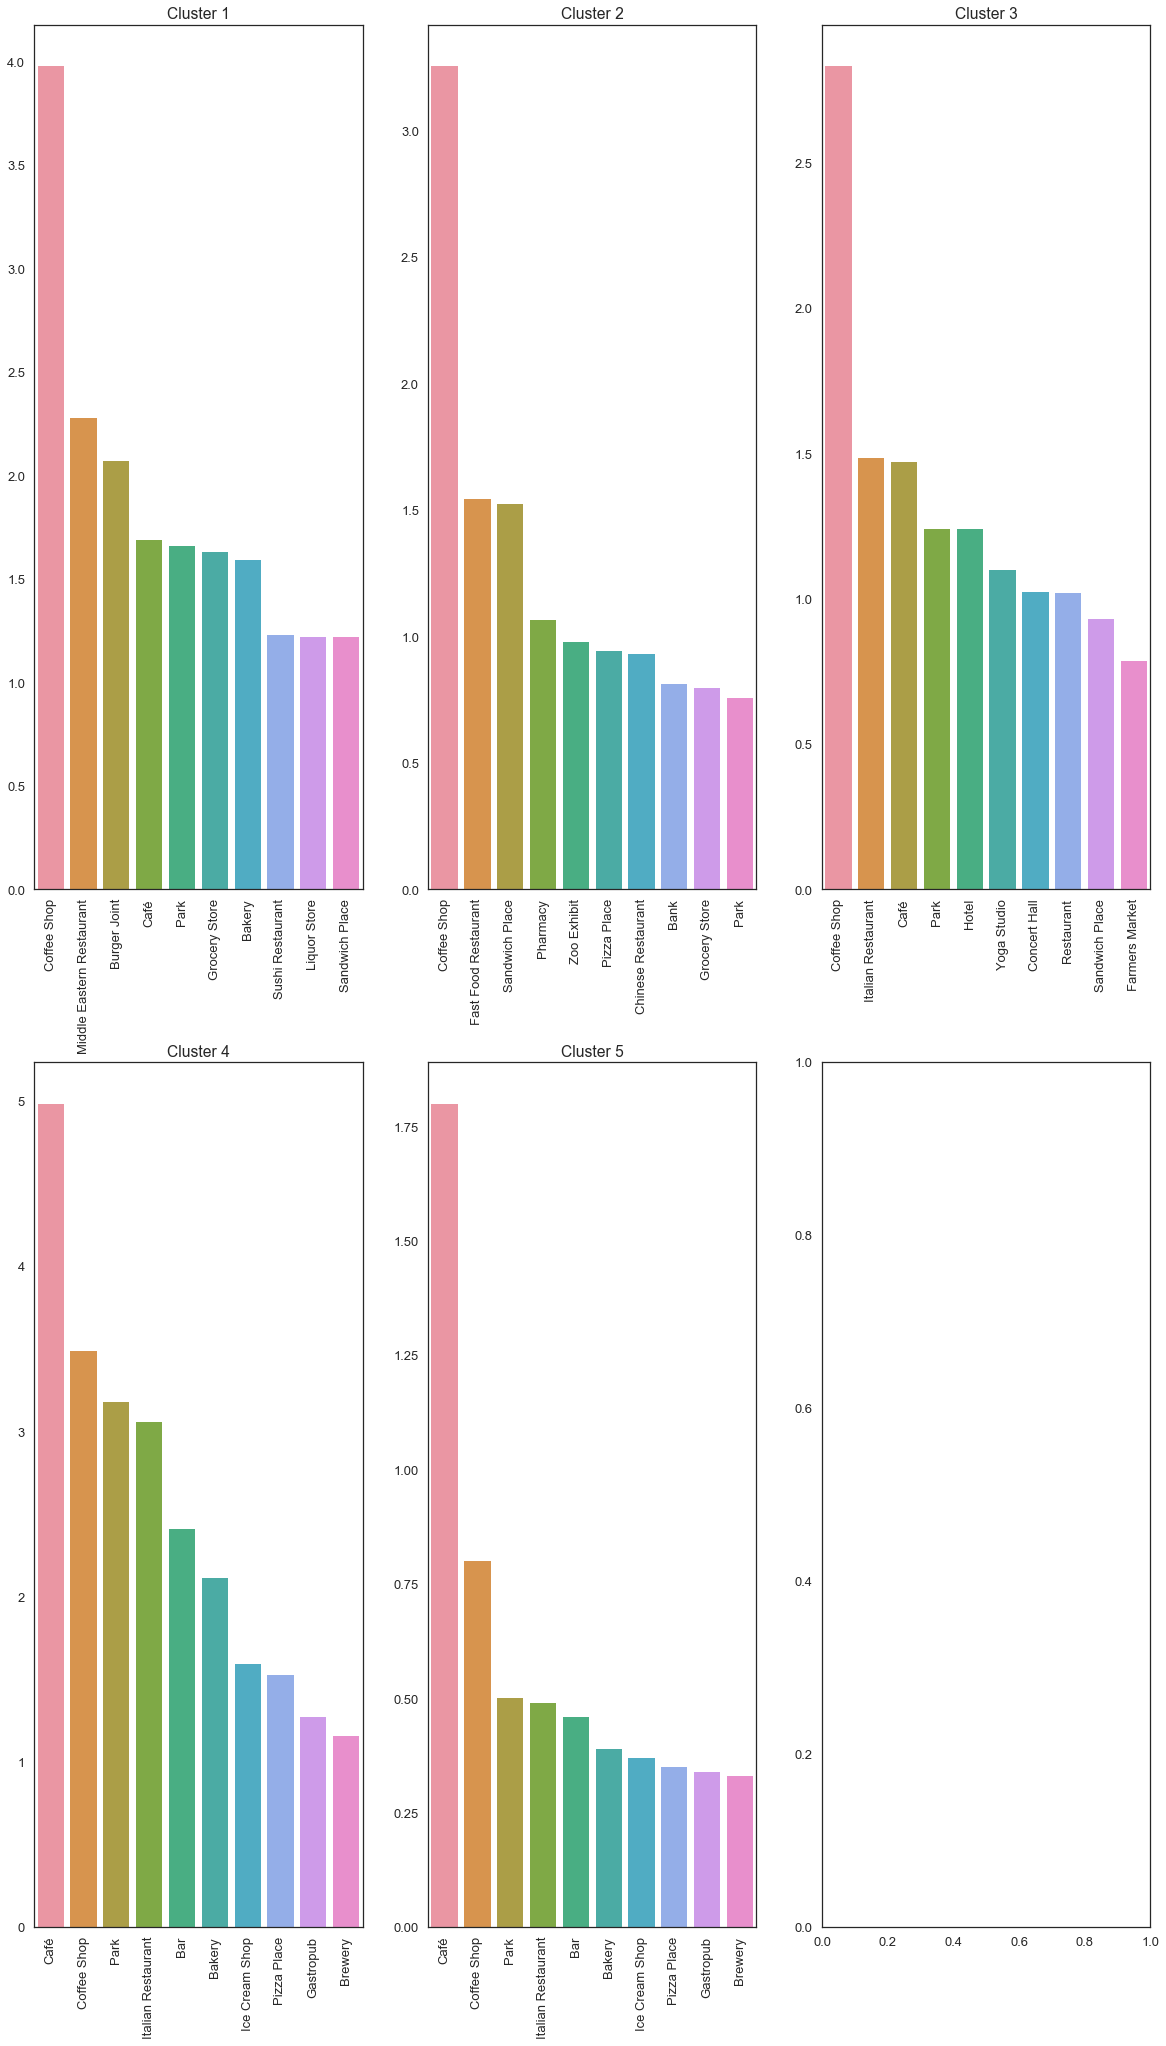

In [359]:
fig, ax =plt.subplots(2,3, figsize=(20, 35))
x1 = top_10_cluster_1.keys()
y1 = top_10_cluster_1.values
ax1 = sns.barplot(x=x1, y=y1, ax=ax[0][0])
ax1.set_xticklabels(x1, rotation=90)
ax1.set_title('Cluster 1')

x2 = top_10_cluster_2.keys()
y2 = top_10_cluster_2.values
ax2 = sns.barplot(x=x2, y=y2, ax=ax[0][1])
ax2.set_xticklabels(x2, rotation=90)
ax2.set_title('Cluster 2')

x3 = top_10_cluster_3.keys()
y3 = top_10_cluster_3.values
ax3 = sns.barplot(x=x3, y=y3, ax=ax[0][2])
ax3.set_xticklabels(x3, rotation=90)
ax3.set_title('Cluster 3')

x4 = top_10_cluster_4.keys()
y4 = top_10_cluster_4.values
ax4 = sns.barplot(x=x4, y=y4, ax=ax[1][0])
ax4.set_xticklabels(x4, rotation=90)
ax4.set_title('Cluster 4')

x5 = top_10_cluster_5.keys()
y5 = top_10_cluster_5.values
ax5 = sns.barplot(x=x5, y=y5, ax=ax[1][1])
ax5.set_xticklabels(x4, rotation=90)
ax5.set_title('Cluster 5')

plt.show()

### Let's use map to visulize Toronto clusters.

In [336]:
#merge data to get lat and lng

all_toronto = pd.merge(toronto_clusters, toronto_final[['Neighborhood', 'Neighborhood Latitude',
                                                      'Neighborhood Longitude']].drop_duplicates(keep='first'), 
                                                                                                 on='Neighborhood', 
                                                                                                 how='inner')

In [337]:
all_toronto.head()

Afghan Restaurant  African Restaurant  Airport  Airport Lounge  \
0                  0                   0        0               0   
1                  0                   0        0               0   
2                  0                   0        0               0   
3                  0                   0        0               0   
4                  0                   0        0               0   

   American Restaurant  Aquarium  Art Gallery  Arts & Crafts Store  \
0                    1         1            2                    2   
1                    1         0            0                    1   
2                    1         0            0                    1   
3                    0         0            0                    0   
4                    1         0            0                    1   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   0                0                0   
1                 1                   0                0                0   
2                 2                   0                0                0   
3                 3                   0                1                0   
4                 1                   0                0                0   

   BBQ Joint  Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0                0           0       0     0    0               0   
1          0                0           0       2     0    0               0   
2          1                0           0       3     0    0               0   
3          0                0           0       1     2    0               0   
4          1                0           0       4     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  Beer Bar  \
0                 2                 0                   1      0         1   
1                 0                 0                   0      0         0   
2                 0                 0                   0      0         0   
3                 0                 0                   0      0         0   
4                 0                 0                   0      0         0   

   Beer Store  Big Box Store  Bike Shop  Bistro  Bookstore  Boutique  \
0           0              0          0       0          0         0   
1           0              0          0       0          2         0   
2           0              0          0       0          1         0   
3           1              1          0       0          0         0   
4           0              0          0       0          1         0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0              0                     0               0        1            0   
1              0                     0               2        0            0   
2              0                     0               3        0            0   
3              0                     0               1        0            0   
4              0                     0               2        2            0   

   Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  \
0       0                0       0         0             0              1   
1       0                0       0         0             2              0   
2       0                5       0         0             1              0   
3       0                0       0         0             2              0   
4       0                0       0         0             4              3   

   Bus Line  Bus Station  Butcher  Café  Camera Store  Campground  \
0         0            0        0     4             0           0   
1         0            0        0     0             0           0   
2         0            0        0     0             0           0   
3         0            0        0     1             0           0   
4         0            0        

In [341]:
latitude = 43.753259
longitude = -79.329656
map_toronto_all = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['blue', 'yellow', 'red', 'orange', 'black']

# add markers to map
for lat, lng, label, cl in zip(all_toronto['Neighborhood Latitude'], 
                           all_toronto['Neighborhood Longitude'], 
                           all_toronto['Neighborhood'],
                           all_toronto['Cluster label']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[cl-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto_all)  
    
map_toronto_all

When we look at top 10 venues all neighbohoods exept third one look alike.  
The third is in red on map. We can observe tendency to build hotels and conductiong cultural life outside of the center.   
A further investigation, what truly makes the difference between clusters, is needed though.